Note: Setting the seed for prng2 at 11 and 12 causes the ELBO to not converge, however using 13 does! RP trick tends to yield less noisy gradients, however it converges slower.

To do: Benchmarks and implementation in Cython

Note: Large parameters can cause gradients to be too large!

In [90]:
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
import scipy.special as s_spec
import scipy
from numpy import sqrt
from numpy import exp
from numpy import log
from scipy.special import digamma
from scipy.special import polygamma

###############generate simulated dataset from Poisson distribution###############

#set parameters 
lambda_data =  5
n = 20 #no. of samplest

#generate dataset
prng1 = RandomState(0)
data = prng1.poisson(lambda_data, n)
x_bar = np.mean(data)
s = np.var(data) #variance is divided by n not n-1

#set prior distribution parameters
a_0 = 4
b_0 = 0.7

#initialise initial variational parameter estimates
prng2 = RandomState(13)

#set parameters for MC gradient evaluation
n_samples = 100
learn = 0.01
n_iter = 10000
#iterations for gradient ascent
#set generalised gradient parameters
n_samples_grg = 1

We assume there are $n$ i.i.d observations and they follow a Poisson distribution so

$L(\textbf{x} | \lambda) = \prod_{i=1}^{n} \frac{\lambda^{x_i}e^\lambda}{x_i!}$ 

Next, we assume that $\lambda$ has a gamma prior distribution 

$\lambda \sim Gamma(\alpha_0,\beta_0)$

where for $X\sim Gamma(\alpha,\beta)$, we use the Gamma density of the form $f(x|\alpha,\beta)=\frac{\beta^\alpha}{\Gamma{(\alpha})}x^{\alpha-1}e^{\beta x}$. Given this likelihood and prior, the posterior is also a Gamma distribution

$\lambda|\textbf{x}\sim Gamma(\alpha_0+\sum_{i=1}^n x_i,\beta_0+n)$

Below we calculate the parameters of the posterior using the above.

In [91]:
###############Calculate analytically posterior parameters###############

#see above for formula
a_pos = a_0+x_bar*n
b_pos = b_0+n

print('The posterior parameters are: (alpha = {:0.2f}, beta = {:0.2f})'.format(a_pos, b_pos))

The posterior parameters are: (alpha = 100.00, beta = 20.70)


We now assume the form of the VB approximation of the posterior is also a Gamma distribution and has pdf 

$q(\textbf{z};\textbf{v})=\frac{{\beta_n}^{\alpha_n}}{\Gamma{(\alpha_n})}\lambda^{\alpha_n-1}e^{\beta_n \lambda}$

We seek to find the optimal value of the parameter vector $\textbf{v}=[\alpha_n,\beta_n]$ by minimising the KL divergence between $q$ and the actual posterior. In this case, the parameters should match exactly since the posterior is also a gamma distribution.

To find the optimal values for the parameters, we seek to maximise the variational lower bound $\mathcal{L}(\textbf{v})$ w.r.t. $\textbf{v}$ where 

$\mathcal{L}(\textbf{v}) = [\log p(\textbf{x},\textbf{z}) - \log q(\textbf{z};\textbf{v})] = \mathbb{E}_{q(\textbf{z},\textbf{v})}[f(\textbf{z})]+\mathbb{H}_{q(\textbf{z},\textbf{v})}[q(\textbf{z},\textbf{v})]$

where $\textbf{x}$ is the data, $\textbf{z}=\lambda$, and $\mathbb{H}_{q(\textbf{z},\textbf{v})}[q(\textbf{z},\textbf{v})]$ is the entropy of $q(\textbf{z},\textbf{v})$.

and $f(\textbf{z})=\log p(\textbf{x},\textbf{z})=\sum_{i=1}^n \log p(x_i|\textbf{z}) + \log p(\textbf{z};\textbf{v})$

We use some form of gradient ascent to maximise the lower bound, and from the literature there are two different ways to do this. The first way is called the *score function* method which utilises the log-derivative trick to estimate the gradient. This method supposedly has high variance and is in general not able to reliably estimate the gradient. The second way is using the *generalised reparameterisation gradient* outlined in the paper by Ruiz et. al. (2016). 

To estimate $\nabla_{\textbf{v}}\mathcal{L}$ using the score function method, we seek to evaluate

$\nabla_{\textbf{v}}\mathcal{L}=\nabla_{\textbf{v}}(\mathbb{E}_{q(\textbf{z},\textbf{v})}[f(\textbf{z})]+\mathbb{H}_{q(\textbf{z},\textbf{v})}[q(\textbf{z},\textbf{v})])=\nabla_{\textbf{v}}\mathbb{E}_{q(\textbf{z}
,\textbf{v})}[f(\textbf{z})]+\nabla_{\textbf{v}}\mathbb{H}_{q(\textbf{z},\textbf{v})}[q(\textbf{z},\textbf{v})]$

We have that $\nabla_{\textbf{v}}\mathbb{E}_{q(\textbf{z},\textbf{v})}[f(\textbf{z})]=\nabla_{\textbf{v}}\int q(\textbf{z},\textbf{v})f(\textbf{z}) dz=\int \nabla_{\textbf{v}} q(\textbf{z},\textbf{v})f(\textbf{z}) dz=\int \frac{q(\textbf{z},\textbf{v})}{q(\textbf{z},\textbf{v})}\nabla_{\textbf{v}} q(\textbf{z},\textbf{v})f(\textbf{z}) dz=\int q(\textbf{z},\textbf{v})f(\textbf{z})\nabla_{\textbf{v}}\log q(\textbf{z},\textbf{v}) = \mathbb{E}_{q(\textbf{z},\textbf{v})}[f(\textbf{z})\nabla_{\textbf{v}}\log q(\textbf{z},\textbf{v})]$

We now need to estimate the final term above and the gradient of the entropy. First, given our choices of likelihood, prior and $q$, we have that

$f(\textbf{z})=\log p(\textbf{x},\textbf{z}) = \alpha_0 \log{\beta_0}-\log{\Gamma(\alpha_0)}-\sum_{i=1}^n x_i! + (\sum_{i=1}^n x_i + \alpha_0 - 1)\log{\textbf{z}}-(\beta_0+n)\textbf{z}$ 

Also, $\nabla_{\textbf{v}}\log q(\textbf{z},\textbf{v})=[\frac{\partial}{\partial\alpha_n}\log q(\textbf{z},\textbf{v}), \frac{\partial}{\partial\beta_n}\log q(\textbf{z},\textbf{v})]^{\intercal}$ where

$\frac{\partial}{\partial\alpha_n}\log q(\textbf{z},\textbf{v}) = \log \beta_n - \psi(\alpha_n)+\log(\textbf{z})$ where $\psi$ is the digamma function.

$\frac{\partial}{\partial\beta_n}\log q(\textbf{z},\textbf{v})=\frac{\alpha_n}{\beta_n}-\textbf{z}$

Finally, the entropy can be shown to be

$\mathbb{H}_{q(\textbf{z},\textbf{v})}[q(\textbf{z},\textbf{v})]=\alpha_n-\log \beta_n + \log \Gamma(\alpha_n) + (1-\alpha_n)\psi(\alpha_n)$

and so we have that the gradient of the entropy is 

$\nabla_{\textbf{v}}\mathbb{H}_{q(\textbf{z},\textbf{v})}[q(\textbf{z},\textbf{v})]=[\frac{\partial}{\partial\alpha_n}\mathbb{H}_{q(\textbf{z},\textbf{v})},\frac{\partial}{\partial\beta_n}\mathbb{H}_{q(\textbf{z},\textbf{v})}]^\intercal$ where

$\frac{\partial}{\partial\alpha_n}\mathbb{H}_{q(\textbf{z},\textbf{v})}=1-\alpha_n \psi_1(\alpha_n)$ where $\psi_n$ is the $n^{th}$ derivative of the digamma function and

$\frac{\partial}{\partial\beta_n}\mathbb{H}_{q(\textbf{z},\textbf{v})} = -\frac{1}{\beta_n}$


In [92]:
###################Define functions used to in the score function estimate###################

def f(z):
    return a_0*np.log(b_0)-np.log(s_spec.digamma(a_0))-np.sum(np.log(scipy.misc.factorial(data)))+ \
(n*x_bar+a_0-1)*np.log(z)-(b_0+n)*z

#transforms variational parameters onto the real line
def T_v(xi):
    v = log(exp(xi)+1)
    return v

def T_inv_v(v):
    xi = log(exp(v)-1)
    return v

def T_v_grad(xi):
    v_g = exp(xi)/(exp(xi)+1)
    return v_g

#calculate elements of the ELBO gradient

def entropy_grad(xi):
    grad = np.empty(2)
    #retrieve parameters
    v = T_v(xi)
    a = v[0]
    b = v[1]
    #retrieve gradient of transform
    v_g = T_v_grad(xi)
    #calculate partial derivatives of entropy
    grad[0] = (1 + (1-a)*s_spec.polygamma(1,a))*v_g[0]
    grad[1] = -1/b*v_g[1]
    return grad

def ln_q_deriv_xi(z,xi):
    #retrieve parameters
    v = T_v(xi)
    a = v[0]
    b = v[1]
    #retrieve gradient of transform
    v_g = T_v_grad(xi)
    #evaluate final gradient
    d_ln_q = np.empty([2,z.size])
    d_ln_q[0] = (np.log(b)-s_spec.digamma(a)+np.log(z))*v_g[0]
    d_ln_q[1] = (a/b-z)*v_g[1]
    return d_ln_q

def lb_grad_score(z, xi):
    grad = np.empty([2,z.size])
    #retrieve parameters
    v = T_v(xi)
    a_n = v[0]
    b_n = v[1]
    #calculate partial derivatives of log(q(z;v))
    q_del = ln_q_deriv_xi(z,v) 
    #set gradient
    grad[0] = f(z)*q_del[0]
    grad[1] = f(z)*q_del[1]
    return grad

def ELBO(xi):
    #retrieve parameters
    v = T_v(xi)
    a_n = v[0]
    b_n = v[1]
    #evaluate expectation of f(z) under q (feed expectation through z terms)
    E_f = a_0*np.log(b_0)-np.log(s_spec.digamma(a_0))-np.sum(np.log(scipy.misc.factorial(data)))+ \
    (n*x_bar+a_0-1)*(s_spec.digamma(a_n) - np.log(b_n))-(b_0+n)*a_n/b_n
    entropy = a_n-np.log(b_n)+np.log(s_spec.gamma(a_n))+(1-a_n)*s_spec.digamma(a_n)
    cost = E_f + entropy
    return cost

Below is the implementation of the score function method. 100 simulations were used to estimate the gradient. The output below give a plot showing the convergence of the ELBO by iteration as well as the initial and final variational parameters.

Initialised parameters:  [ 77.77024106  23.754122  ]
Final variational parameters:  [ 79.77345863  16.63727641]
Converged ELBO:  -42.4434989512
ELBO of analytical posterior parameters:  -42.4268611225
Mean of VB approximation 4.7948628538
Mean of analytic posterior:  4.8309178744


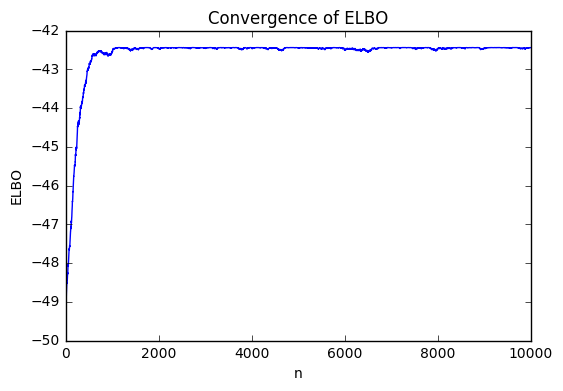

In [93]:
###############implement score function method###############

#initialise parameters randomly
xi_0 = prng2.uniform(0,100,2)
xi = xi_0
#convert using transformation to parameter space
v = T_v(xi)
#print initialisation of parameter
print("Initialised parameters: ",v)
#initialise graph vectors
cost_graph = np.empty(n_iter)
grad_var = np.empty([n_iter,2])

for i in range(0,n_iter):
    samples = np.random.gamma(v[0],1/v[1],n_samples)
    grad_vect = lb_grad_score(samples, xi) #for variance
    grad = np.mean(grad_vect,axis=1) + entropy_grad(xi)
    #update variance of gradient for comparison to RP
    grad_var[i] = np.var(grad_vect, axis=1)
    #update transformed variational parameters
    xi = xi + learn*grad
    #convert back to parameter space
    v = T_v(xi)
    #record the cost for plotting to check convergence
    c = ELBO(xi)
    cost_graph[i]= c
    
print("Final variational parameters: ",v)

#summary metrics - compare to analytical result
print('Converged ELBO: ',c) 
print('ELBO of analytical posterior parameters: ', ELBO(T_inv_v([a_pos,b_pos])))
print('Mean of VB approximation',v[0]/v[1])
print('Mean of analytic posterior: ',a_pos/b_pos)

#check convergence

plt.plot(np.linspace(1,n_iter,n_iter), cost_graph, label='Score function method')
plt.ylabel('ELBO')
plt.xlabel('n')
plt.title('Convergence of ELBO')
plt.show()

It is clear from the above plot that the ELBO has converged. It is also quite close to the ELBO evaluated using the analytically solved parameters of the posterior, which indicates the fit will likely be close.

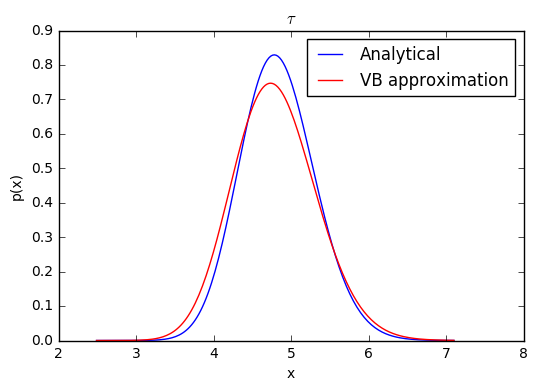

In [94]:
#set up plot for pdf of posterior under VB
vb_mean = v[0]/v[1]
vb_sd = vb_mean/v[1]
x = np.linspace(vb_mean-8*vb_sd, vb_mean+8*vb_sd, 200) #generate sample space for plotting density
pdf_vb = stats.gamma.pdf(x, v[0], scale=1/v[1])

#set up plot for pdf of analytical posterior
a_mean = a_pos/b_pos
a_sd = a_mean/b_pos
#x = np.linspace(a_mean-4*a_sd, a_mean+4*a_sd, 200)
pdf_a = stats.gamma.pdf(x, a_pos, scale=1/b_pos)

#conditional/marginal for tau
plt.plot(x, pdf_a, 'b', label='Analytical')
plt.plot(x, pdf_vb, 'r', label='VB approximation')
plt.ylabel('p(x)')
plt.xlabel('x')
plt.legend()
plt.title(r'$\tau$')
plt.show()

It is clear from the above that the VB approximation is very close, but not quite a perfect fit. This is understandable given the fixed learning rate which will cause oscillations in the parameters around the true value when nearing convergence.

Now we use the generalised reparameterisation gradient by Ruiz et. al. to try and find a low variance estimate of the gradient. See page 3 of the paper for formulas used. Similar plots are provided for this method.

In [117]:
def T(e, xi):
    #retrieve parameters
    v = T_v(xi)
    a_n = v[0]
    b_n = v[1]
    return np.exp(e*np.sqrt(s_spec.polygamma(1,a_n))+s_spec.digamma(a_n)-np.log(b_n))

def Tinv(z, xi):
    #retrieve parameters
    v = T_v(xi)
    a_n = v[0]
    b_n = v[1]
    return (np.log(z)-s_spec.digamma(a_n) + np.log(b_n))/np.sqrt(s_spec.polygamma(1,a_n))

def h(e, xi):
    #retrieve parameters
    v = T_v(xi)
    a = v[0]
    b = v[1]
    h = np.empty([2,e.size])
    pg_1 = s_spec.polygamma(1,a)
    #bring in gradient of T_v
    v_g = T_v_grad(xi)
    #calculate h
    h[0] = T(e, v)*(e*s_spec.polygamma(2,a)/(2*np.sqrt(pg_1))+ pg_1)*v_g[0]
    h[1] = -T(e, v)/b*v_g[1]
    return h

def u(e, v):
    #retrieve parameters
    v = T_v(xi)
    a = v[0]
    b = v[1]
    #bring in gradient of T_v
    v_g = T_v_grad(xi)
    #set up output for u
    u = np.empty([2,e.size])
    pg_1 = s_spec.polygamma(1,a)
    pg_2 = s_spec.polygamma(2,a)
    u[0] = (e*pg_2/(2*np.sqrt(pg_1))+ pg_1 + pg_2/(2*pg_1))*v_g[0]
    u[1] = -1/b*v_g[1]
    return u

#calculate Fisher information of variational distribution for natural gradient
def I(xi):
    #find information w.r.t. v
    v=T_v(xi)
    a = v[0]
    b = v[1]
    I_v = np.zeros([2,2])
    I_v[0,0] = log(b)**2+2*log(b)*(digamma(a)-log(b))-2*digamma(a)*log(b)+digamma(a)**2-\
        (2*digamma(a)-1)*(digamma(a)-log(b))+log(2)
    I_v[1,1]=a/b**2
    I_v[0,1]=a/b*(digamma(a)-digamma(a+1))
    I_v[1,0]=I_v[0,1]
    #evaluate Jacobian of transformation
    J = T_v_J(xi)
    return np.matmul(np.matmul(np.transpose(J),I_v),J)

#evaluate Jacobian of transformation of variation parameters for natural gradient

def T_v_J(xi):
    v_g = exp(xi)/(exp(xi)+1)
    #initalise Jacobian
    J = np.zeros([2,2])
    J[0,0]=v_g[0]
    J[1,1]=v_g[1]
    return J

#evaluate gradient

def f_deriv(z):
    return (x_bar*n+a_0-1)/z-(b_0+n)

def ln_q_deriv_z(z,v):
    a = v[0]
    b = v[1]
    return (a-1)/z-b

def g_corr(z, xi):
    g_corr = np.empty([2,z.size])
    g_corr = f(z)*(ln_q_deriv_z(z,xi)*h(Tinv(z,xi),xi)+ln_q_deriv_xi(z,xi)+u(Tinv(z,xi),xi))
    return g_corr

Initialised parameters:  [ 77.77024106  23.754122  ]
Final variational parameters:  [ 76.60639565  15.50472688]
Converged ELBO:  -42.4718825101
ELBO of analytical posterior parameters:  -42.4268611225
Mean of VB approximation 4.94084134768
Mean of analytic posterior:  4.8309178744


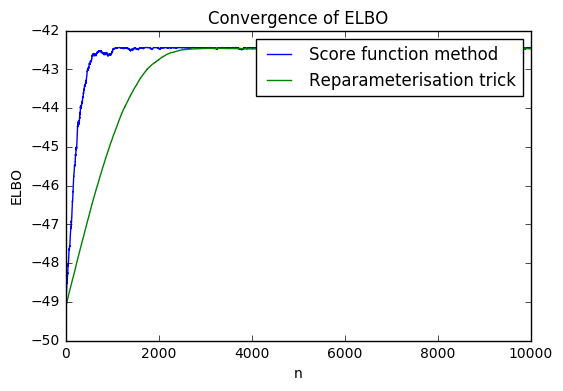

In [96]:
#########Implement reparameterisation trick

#initalise parameters consistent with score method
xi = xi_0
v = T_v(xi)
print("Initialised parameters: ",v)
#initialise graphing arrays
cost_graph1 = np.empty(n_iter)
grad_var1 = np.empty([n_iter,2])

for i in range(0,n_iter):
    samples = np.random.gamma(v[0],1/v[1],n_samples_grg)
    g_rep = f_deriv(samples)*h(Tinv(samples,xi),xi)
    g_cor = g_corr(samples,xi)
    #calculate gradient
    grad_vect = g_rep + g_cor
    grad_rp = np.mean(grad_vect) + entropy_grad(xi)
    #store variance of gradient to compare to score
    grad_var1[i] = np.var(grad_vect, axis=1)
    #update transformed variational parameters
    xi = xi + learn*grad_rp
    v = T_v(xi)
    #record the cost for plotting to check convergence
    c = ELBO(xi)
    cost_graph1[i]= c

print("Final variational parameters: ",v)

#summary metrics - compare to analytical result
print('Converged ELBO: ',c) 
print('ELBO of analytical posterior parameters: ', ELBO(T_inv_v([a_pos,b_pos])))
print('Mean of VB approximation',v[0]/v[1])
print('Mean of analytic posterior: ',a_pos/b_pos)

#check convergence of ELBO
plt.plot(np.linspace(1,n_iter,n_iter), cost_graph, label='Score function method')
plt.plot(np.linspace(1,n_iter,n_iter), cost_graph1, label='Reparameterisation trick')
plt.ylabel('ELBO')
plt.xlabel('n')
plt.legend()
plt.title('Convergence of ELBO')
plt.show()

This plot seems to indicate that the gradient is a lot less noisy under the reparameterisation gradient (by smoothness of the line). However, it converges a lot more slowly than the score function method. We now plot histogram of the variance of the gradient for both methods to investigate more formally.

In [113]:
grad_var1[:,0].shape

(10000,)

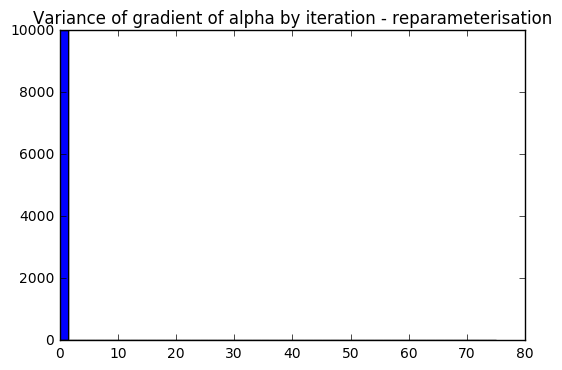

0.00750465


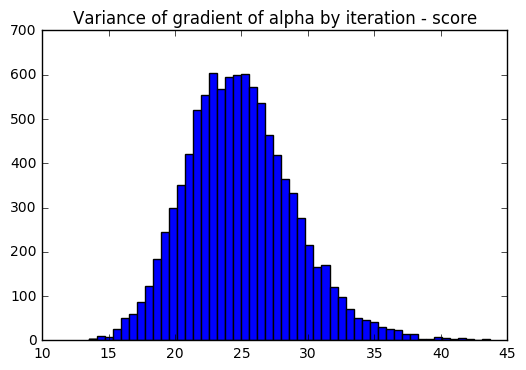

24.9400557288


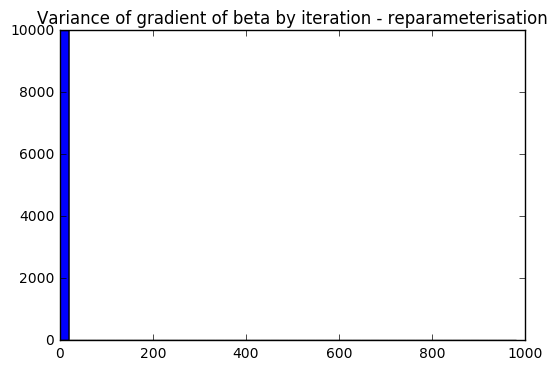

0.098


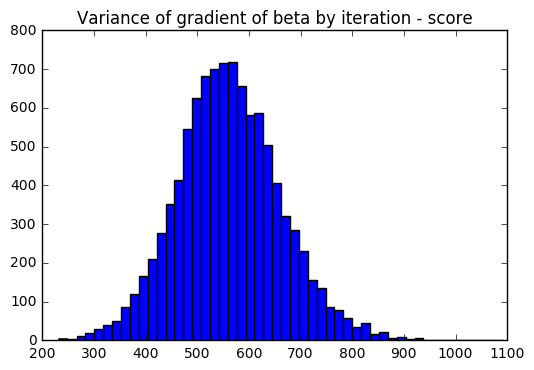

561.776333499


In [116]:
#analysis of gradient variance graphs
plt.title("Variance of gradient of alpha by iteration - reparameterisation")
plt.hist(grad_var1[:,0],bins=50)
plt.show()

print(np.mean(grad_var1[:,0]))

plt.title("Variance of gradient of alpha by iteration - score")
plt.hist(grad_var[:,0],bins=50)
plt.show()

print(np.mean(grad_var[:,0]))

plt.title("Variance of gradient of beta by iteration - reparameterisation")
plt.hist(grad_var1[:,1],bins=50)
plt.show()

print(np.mean(grad_var1[:,1]))

plt.title("Variance of gradient of beta by iteration - score")
plt.hist(grad_var[:,1],bins=50)
plt.show()

print(np.mean(grad_var[:,1]))

The above clearly indicates that the reparameterisation gradient has almost 0 variance while the score function method has extremely high variance. Below we plot the VB approximation provided by the reparameterisation gradient method.

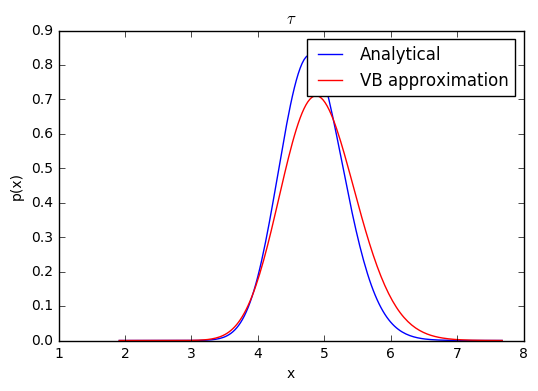

In [98]:
#set up plot for pdf of posterior under VB
vb_rp_mean = v[0]/v[1]
vb_rp_sd = vb_mean/v[1]
#x = np.linspace(0,150,200)
x = np.linspace(vb_mean-10*vb_sd, vb_mean+10*vb_sd, 200) #generate sample space for plotting density
pdf_vb_rp = stats.gamma.pdf(x, v[0], scale=1/v[1])

#set up plot for pdf of analytical posterior
#x = np.linspace(a_mean-4*a_sd, a_mean+4*a_sd, 200)
pdf_a = stats.gamma.pdf(x, a_pos, scale=1/b_pos)

#conditional/marginal for tau
plt.plot(x, pdf_a, 'b', label='Analytical')
plt.plot(x, pdf_vb_rp, 'r', label='VB approximation')
plt.ylabel('p(x)')
plt.xlabel('x')
plt.legend()
plt.title(r'$\tau$')
plt.show()

One thing to note is that both methods are susceptible to local maxima and may converge prematurely depending on parameter initialisation. In addition, I have tried adaptive step sizes and even the natural gradient (Honkela et. al. 2007?, https://www.hiit.fi/u/ahonkela/papers/Honkela07ICONIP.pdf) which seems to offer far superior convergence as expected.

In [99]:
#set adagrad parameters
eta = 0.000001
kappa = 1e-16

###adaptive learning rate calculation (AdaGrad)
def learn_ada(g,s,i):
    if np.sum(np.absolute(s)) == 0:
        s1 = np.square(g)
    else:
        s1 = 0.1*np.square(g)+0.9*s
    #update learning rate
    rho = eta*i**(-0.5+kappa)/(1+sqrt(s1))
    return rho

We now implement the reparameterisation trick using the natural gradient instead of the standard Euclidean gradient.

Initialised parameters:  [ 77.77024106  23.754122  ]
Final variational parameters:  [ 24.19729857   4.96212445]
Converged ELBO:  -43.2963234859
ELBO of analytical posterior parameters:  -42.4268611225
Mean of VB approximation 4.87639896932
Mean of analytic posterior:  4.8309178744


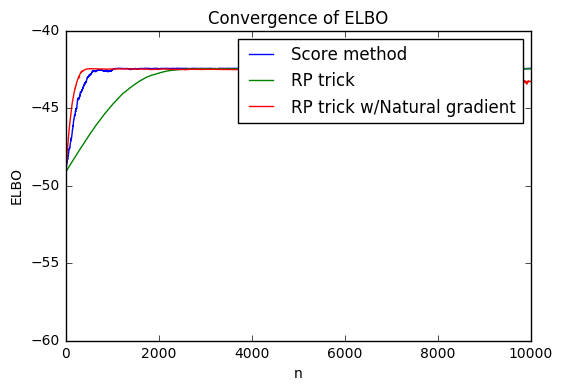

In [118]:
#initalise parameters consistent with score method
xi = xi_0
v = T_v(xi)
print("Initialised parameters: ",v)
#initialise graphing arrays
cost_graph2 = np.empty(n_iter)
grad_var1 = np.empty([n_iter,2])
#initialise step size vectors and params
step = np.empty(2)
step_prev = np.zeros(2)
rho = np.empty(2)

for i in range(1,n_iter):
    samples = np.random.gamma(v[0],1/v[1],n_samples_grg)
    g_rep = f_deriv(samples)*h(Tinv(samples,xi),xi)
    g_cor = g_corr(samples,xi)
    #calculate gradient
    grad_vect = g_rep + g_cor
    grad_rp = np.mean(grad_vect) + entropy_grad(xi)
    #store variance of gradient to compare to score
    grad_var1[i] = np.var(grad_vect, axis=1)
    #calculate Fisher information matrix for natural gradient
    xi_I = I(xi)
    #print(xi_I,np.linalg.inv(xi_I),T_v_J(xi), xi)
    #calculate adaptive learning rate
    rho = learn_ada(grad_rp, step_prev, i)
    step_prev = step
    #update transformed variational parameters
    xi = xi + learn*np.matmul(np.linalg.inv(xi_I),grad_rp)
    v = T_v(xi)
    #record the cost for plotting to check convergence
    c = ELBO(xi)
    cost_graph2[i]= c

print("Final variational parameters: ",v)

#summary metrics - compare to analytical result
print('Converged ELBO: ',c) 
print('ELBO of analytical posterior parameters: ', ELBO(T_inv_v([a_pos,b_pos])))
print('Mean of VB approximation',v[0]/v[1])
print('Mean of analytic posterior: ',a_pos/b_pos)

#check convergence of ELBO
plt.plot(np.linspace(1,n_iter,n_iter), cost_graph, label='Score method')
plt.plot(np.linspace(1,n_iter,n_iter), cost_graph1, label='RP trick')
plt.plot(np.linspace(1,n_iter,n_iter), cost_graph2, label='RP trick w/Natural gradient')
plt.ylim([-60,-40])
plt.ylabel('ELBO')
plt.xlabel('n')
plt.legend()
plt.title('Convergence of ELBO')
plt.show()

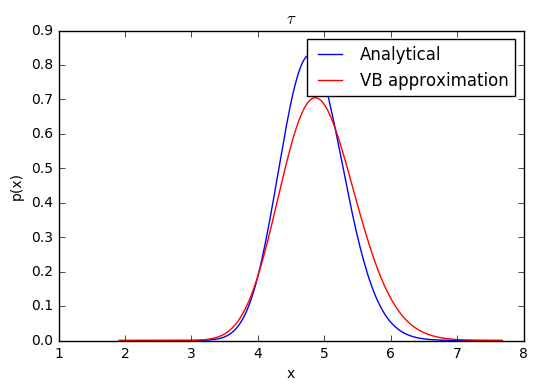

In [105]:
#set up plot for pdf of posterior under VB
pdf_vb_rp_ng = stats.gamma.pdf(x, v[0], scale=1/v[1])

#conditional/marginal for tau
plt.plot(x, pdf_a, 'b', label='Analytical')
plt.plot(x, pdf_vb_rp_ng, 'r', label='VB approximation')
plt.ylabel('p(x)')
plt.xlabel('x')
plt.legend()
plt.title(r'$\tau$')
plt.show()